In [147]:
import pandas as pd
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm 
import datetime
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [3]:
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import platform
from matplotlib import font_manager, rc

plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')
else:
    print('Unknown system... sorry~~')

#### 전처리시 활용한 코드들 

In [18]:
#공휴일 찾기 
"""
holidays = [20180923, 20180924, 20180925, 20181003, 20181009, 20181225, 
           20190101, 20190204, 20190205, 20190206, 20190301, 20190505,
           20190512, 20190606, 20190815, 20190912, 20190913, 20190914,
            20191003, 20191009, 20191225]
            
            
reg_df["holiday"] = reg_df["base_date"].apply(lambda x : 1 if x in holidays else 0)# 공휴일일 경우 1. 
reg_df["holiandweekend"] = reg_df["holiday"] + reg_df["weekend"] #공휴일, 주말일 경우 1 
"""


In [299]:
### 1일전, 2일전 컬럼 추가하는 코드  
"""
tourist_1before = list(df["총관광객"])
tourist_2before = list(df["총관광객"])
tourist_1before.insert(0, 0)
tourist_1before = tourist_1before[:-1]
tourist_2before.insert(0, 0)
tourist_2before.insert(0, 0)
tourist_2before = tourist_2before[:-2]
df["tourist_-1day"] = tourist_1before
df["tourist_-2day"] = tourist_2before
"""

In [200]:
# 일별 관광객 입도 현황 데이터(from 제주관광협회) 전처리
"""
dailydf = pd.read_csv("data/daily_tourist.csv", encoding="utf-8-sig")
dailydf["base_date"] = dailydf["date"].apply(lambda x : x[:2] + x[4:6])
dailydf["base_date"] = dailydf["year"].astype(str) + dailydf["base_date"]
dailydf["base_date"] = dailydf["base_date"].astype(int)
dailydf["총관광객"] = dailydf["총관광객"].apply(lambda x : int(x.replace(",", "")))
dailydf["내국인"] = dailydf["내국인"].apply(lambda x : int(x.replace(",", "")))
"""

In [8]:
# 제주도 날씨 데이터 (from 기상청) 전처리
"""
weather = pd.read_csv("data/jeju_weather_raw.csv", encoding="cp949")
weather.fillna(0, inplace = True)
weather = weather[weather["지점명"] == "제주"]

def change_dataformat(data):
    dates = data.split(".")
    date2 = "0"+dates[1] if len(dates[1]) == 1 else dates[1]
    date3 = "0"+dates[2] if len(dates[2]) == 1 else dates[2]
    return dates[0] + date2 + date3
 
weather["일시"] = weather["일시"].apply(change_dataformat)
weather["일시"] = weather["일시"].astype(int)
"""

#### columns 
- 'base_date' : 기준일
- 'airport' : 기준일에 공항에서 버스에 탑승한 탑승객 수 
    - 'airport_-1day' : 기준일 하루전 공항에서 버스에 탑승한 탑승객 수 
    - 'airport_-2day' : 기준일 이틀전 공항에서 버스에 탑승한 탑승객 수 
- '총관광객' : 기준일의 제주도 입도 관광객 수(제주 관광협회 자료)
    - 'tourist_-1day' : 기준일 하루전 제주도 입도 관광객 수  
    - 'tourist_-2day' : 기준일 이틀전 제주도 입도 관광객 수 
- '내국인' : 기준일의 제주도 입도 관광객 중 내국인 관광객의 수(제주 관광협회 자료)
- 'base_day' : 기준일의 요일(categorical 변수)
    - 'fri', 'mon', 'sat', 'sun', 'thu', 'tue', 'wed' : 기준일의 요일(one-hot encoding) 
- '평균기온' : 기준일의 제주도 평균기온 
- '강수 계속시간(hr)' : 기준일의 제주도 강수 계속시간(24시간 중 비가 내린 시간)
- '일강수량(mm)' : 기준일의 제주도 일강수량
- '최대 풍속(m/s)' : 기준일의 제주도 최대 풍속
- '평균 풍속(m/s)' : 기준일의 제주도 평균 풍속
- 'weekend' : 주말/주중 (주말인 경우 1)
- 'holiday' : 공휴일 (공휴일인 경우 1)
- 'holiandweekend' : 주말, 공휴일인 경우 1
- 'std_airport' : 기준일에 공항에서 버스에 탑승한 탑승객 수 -> standard scaling
- 'month' : 월(categorical 변수)
    - '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12' : 기준일의 월(one-hot encoding) 
- '관광지하차관광객(y)' : 관광지에 하차한 관광객의 수(y). 클러스터링 결과 관광객으로 추정되는 클러스터에 속한 탑승객들 중 주요 관광지(관광객 클러스터와 도민 클러스터의 이용량 격차가 벌어진 정류장 기준)에 내린 사람의 수를 일별로 구함 

In [165]:
df = pd.read_csv("data/df_regression.csv", encoding="utf-8-sig")

In [163]:
df.head()

,base_date,airport,airport_-1day,airport_-2day,총관광객,내국인,tourist_-1day,tourist_-2day,base_day,fri,...,04,05,06,07,08,09,10,11,12,관광지하차관광객(y)
0,20180701,3910,0,0,31614,27975,0,0,sun,0,...,0,0,0,1,0,0,0,0,0,1992
1,20180702,4209,3910,0,28653,25817,31614,0,mon,0,...,0,0,0,1,0,0,0,0,0,2401
2,20180703,3763,4209,3910,27514,23979,28653,31614,tue,0,...,0,0,0,1,0,0,0,0,0,2573
3,20180704,4472,3763,4209,37169,33461,27514,28653,wed,0,...,0,0,0,1,0,0,0,0,0,3798
4,20180705,3708,4472,3763,40192,36461,37169,27514,thu,0,...,0,0,0,1,0,0,0,0,0,3030


<AxesSubplot:xlabel='airport', ylabel='관광지하차관광객(y)'>

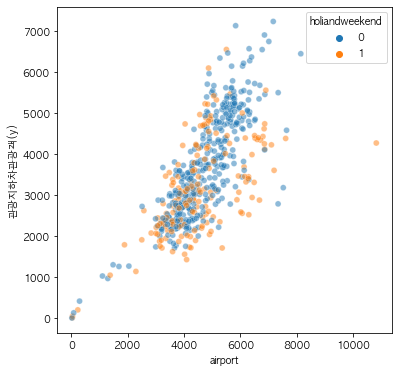

In [145]:
plt.figure(figsize = (6, 6))
sns.scatterplot(data = df, 
               x = "airport", 
               y = "관광지하차관광객(y)",
                cmap = "Pastel2",
                hue = "holiandweekend", 
               alpha = 0.5)

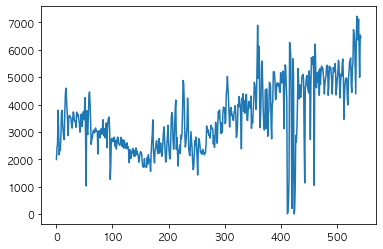

In [128]:
plt.plot(df["관광지하차관광객(y)"])

In [ ]:
# 월에 따라서 공항 탑승객과 관광지 하차 관광객의 관계가 달라지는 것으로 보임
# 추후 월에 따라 차이를 보이는 원인을 찾아볼 수 있을 것으로 사료됨 

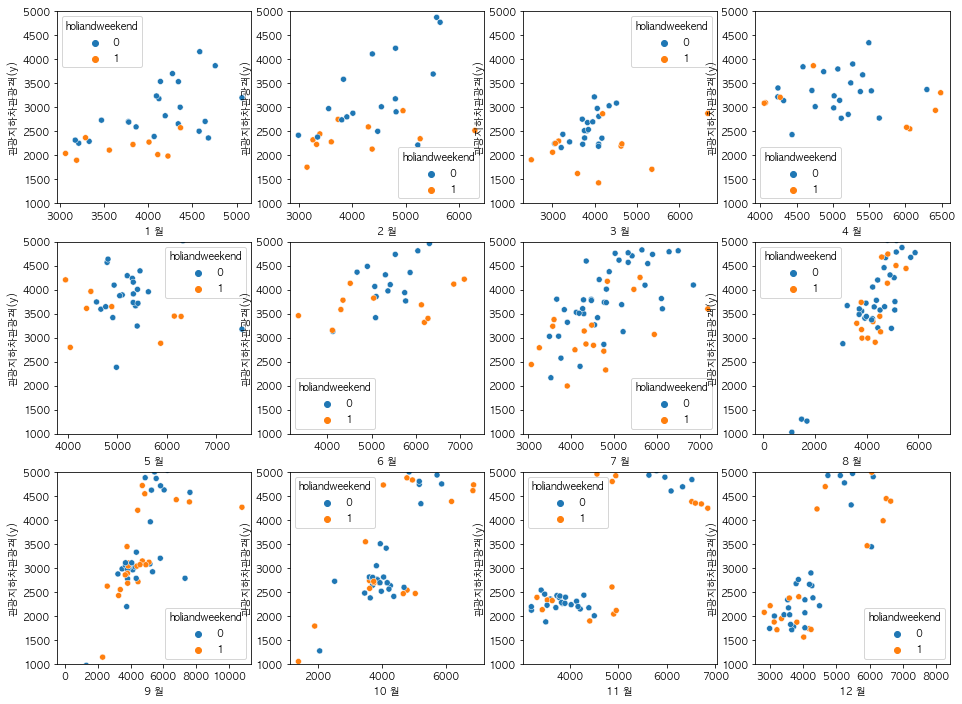

In [144]:
plt.figure(figsize = (16, 12))

for i in list(df["month"].unique()):
    
    plt.subplot(3, 4, i)
    sns.scatterplot(data = df[df["month"] == i], 
                   x = "airport", 
                   y = "관광지하차관광객(y)", 
                   hue = "holiandweekend")
    plt.ylim([1000, 5000])
    plt.xlabel(f"{i} 월")
    
   

<AxesSubplot:>

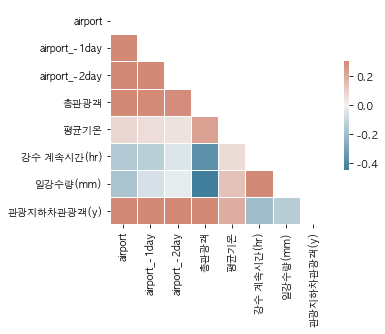

In [130]:

corr = df[['airport', 'airport_-1day', 'airport_-2day',
       '총관광객', '평균기온', '강수 계속시간(hr)', '일강수량(mm)', "관광지하차관광객(y)" ]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)



sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

- OLS
- 사용 컬럼 : 당일(base_date 기준) 공항에서 버스에 탑승한 승객 수, 1일 전 공항에서 버스에 탑승한 승객 수, 2일 전 공항에서 버스에 탑승한 승객 수 

In [131]:
X = df[["airport", 'airport_-1day', 'airport_-2day']]
X_add = sm.add_constant(X, has_constant = "add") 
y = df[["관광지하차관광객(y)"]]
X_train, X_test, y_train, y_test = train_test_split(X_add, y, 
                                                   test_size = 0.3, 
                                                   random_state = 13)

lm = sm.OLS(y_train, X_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            관광지하차관광객(y)   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     203.4
Date:                Sun, 23 May 2021   Prob (F-statistic):           2.26e-78
Time:                        17:37:14   Log-Likelihood:                -3056.3
No. Observations:                 380   AIC:                             6121.
Df Residuals:                     376   BIC:                             6136.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -863.0477    184.793     -4.670      0.000   -1226.405    -499.691
airport           0.4992      0.041     12.093      0.000       0.418       0.580
airport_-1day     0.2174      0.050      4.368      0.000       0.120       0.315
airport_-2day     0.2240      0.041      5.524      0.000       0.144       0.304
==============================================================================
Omnibus:                       27.759   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.914
Skew:                           0.299   Prob(JB):                     5.40e-17
Kurtosis:                       5.091   Cond. No.                     3.92e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.92e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [122]:

pred_tr = lm.predict(X_train)
pred_test = lm.predict(X_test)
rmse_tr = (np.sqrt(mean_squared_error(y_train, pred_tr)))
rmse_test = (np.sqrt(mean_squared_error(y_test, pred_test)))



print('RMSE of Train Data: ', rmse_tr)
print('RMSE of Test Data: ', rmse_test)

RMSE of Train Data:  752.9679830876335
RMSE of Test Data:  758.0926486551502


- OLS
- 사용 컬럼 : 당일(base_date 기준) 공항에서 버스에 탑승한 승객 수, 1일 전 공항에서 버스에 탑승한 승객 수, 
    2일 전 공항에서 버스에 탑승한 승객 수, 날씨(평균기온, 강수 계속시간, 일 강수량) 

In [138]:
X = df[["airport", 'airport_-1day', 'airport_-2day', "평균기온", '강수 계속시간(hr)', '일강수량(mm)' ]]
X_add = sm.add_constant(X, has_constant = "add") 
y = df[["관광지하차관광객(y)"]]
X_train, X_test, y_train, y_test = train_test_split(X_add, y, 
                                                   test_size = 0.3, 
                                                   random_state = 13)

lm = sm.OLS(y_train, X_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            관광지하차관광객(y)   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     112.0
Date:                Sun, 23 May 2021   Prob (F-statistic):           2.56e-80
Time:                        17:39:20   Log-Likelihood:                -3043.8
No. Observations:                 380   AIC:                             6102.
Df Residuals:                     373   BIC:                             6129.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1138.9153    199.121     -5.720      0.000   -1530.457    -747.374
airport           0.4795      0.041     11.674      0.000       0.399       0.560
airport_-1day     0.2099      0.049      4.301      0.000       0.114       0.306
airport_-2day     0.2286      0.039      5.787      0.000       0.151       0.306
평균기온             23.7019      5.115      4.634      0.000      13.645      33.759
강수 계속시간(hr)     -15.1290     10.421     -1.452      0.147     -35.620       5.362
일강수량(mm)         -1.0889      1.795     -0.606      0.545      -4.619       2.442
==============================================================================
Omnibus:                       36.390   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.320
Skew:                           0.341   Prob(JB):                     6.12e-28
Kurtosis:                       5.729   Cond. No.                     4.35e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [125]:

pred_tr = lm.predict(X_train)
pred_test = lm.predict(X_test)
rmse_tr = (np.sqrt(mean_squared_error(y_train, pred_tr)))
rmse_test = (np.sqrt(mean_squared_error(y_test, pred_test)))



print('RMSE of Train Data: ', rmse_tr)
print('RMSE of Test Data: ', rmse_test)

RMSE of Train Data:  728.4917708871244
RMSE of Test Data:  724.1947991593745


- OLS
- 사용 컬럼 : 당일(base_date 기준) 공항에서 버스에 탑승한 승객 수, 1일 전 공항에서 버스에 탑승한 승객 수, 
    2일 전 공항에서 버스에 탑승한 승객 수, 날씨(평균기온, 강수 계속시간, 일 강수량, 주말및공휴일) 

In [133]:
X = df[["airport", 'airport_-1day', 'airport_-2day', "평균기온", '강수 계속시간(hr)', '일강수량(mm)', 
                    "holiandweekend"]]
X_add = sm.add_constant(X, has_constant = "add") 
y = df[["관광지하차관광객(y)"]]
X_train, X_test, y_train, y_test = train_test_split(X_add, y, 
                                                   test_size = 0.3, 
                                                   random_state = 13)

lm = sm.OLS(y_train, X_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            관광지하차관광객(y)   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     99.18
Date:                Sun, 23 May 2021   Prob (F-statistic):           4.35e-81
Time:                        17:38:08   Log-Likelihood:                -3039.5
No. Observations:                 380   AIC:                             6095.
Df Residuals:                     372   BIC:                             6126.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -962.1895    206.244     -4.665      0.000   -1367.739    -556.640
airport            0.4908      0.041     12.016      0.000       0.410       0.571
airport_-1day      0.1621      0.051      3.178      0.002       0.062       0.262
airport_-2day      0.2448      0.039      6.198      0.000       0.167       0.322
평균기온              23.8021      5.064      4.700      0.000      13.845      33.760
강수 계속시간(hr)      -15.9995     10.322     -1.550      0.122     -36.295       4.297
일강수량(mm)          -1.2393      1.778     -0.697      0.486      -4.736       2.258
holiandweekend  -247.3406     84.784     -2.917      0.004    -414.056     -80.626
==============================================================================
Omnibus:                       35.641   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.337
Skew:                           0.399   Prob(JB):                     3.64e-23
Kurtosis:                       5.427   Cond. No.                     4.59e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [134]:

pred_tr = lm.predict(X_train)
pred_test = lm.predict(X_test)
rmse_tr = (np.sqrt(mean_squared_error(y_train, pred_tr)))
rmse_test = (np.sqrt(mean_squared_error(y_test, pred_test)))



print('RMSE of Train Data: ', rmse_tr)
print('RMSE of Test Data: ', rmse_test)

RMSE of Train Data:  720.29873566381
RMSE of Test Data:  712.8239620807933


$$ (Tourist∩BusPassenger) = -863.0477 + 0.4992(Airport BusPassenger) + 0.2174(Airport -1Day) + 0.2240(Airport -2Day)$$ 	

- OLS
- 사용 컬럼 : 당일(base_date 기준) 제주 입도 관광객 수, 1일 전 제주 입도 관광객 수, 2일 전 제주 입도 관광객 수 

In [140]:
X = df[["총관광객", "tourist_-1day", "tourist_-2day" ]]
X_add = sm.add_constant(X, has_constant = "add") 
y = df[["관광지하차관광객(y)"]]
X_train, X_test, y_train, y_test = train_test_split(X_add, y, 
                                                   test_size = 0.3, 
                                                   random_state = 13)

lm = sm.OLS(y_train, X_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            관광지하차관광객(y)   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     30.45
Date:                Sun, 23 May 2021   Prob (F-statistic):           1.20e-17
Time:                        17:40:33   Log-Likelihood:                -3198.2
No. Observations:                 380   AIC:                             6404.
Df Residuals:                     376   BIC:                             6420.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -977.7663    487.812     -2.004      0.046   -1936.947     -18.586
총관광객              0.0726      0.012      5.955      0.000       0.049       0.097
tourist_-1day     0.0078      0.014      0.564      0.573      -0.019       0.035
tourist_-2day     0.0295      0.012      2.489      0.013       0.006       0.053
==============================================================================
Omnibus:                        9.649   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               16.621
Skew:                           0.086   Prob(JB):                     0.000246
Kurtosis:                       4.010   Cond. No.                     6.14e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.14e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [141]:

pred_tr = lm.predict(X_train)
pred_test = lm.predict(X_test)
rmse_tr = (np.sqrt(mean_squared_error(y_train, pred_tr)))
rmse_test = (np.sqrt(mean_squared_error(y_test, pred_test)))



print('RMSE of Train Data: ', rmse_tr)
print('RMSE of Test Data: ', rmse_test)

RMSE of Train Data:  1093.800942841297
RMSE of Test Data:  1143.354634854195


 - Random Forest Regression 
 - 사용 컬럼 :  당일(base_date 기준) 제주 입도 관광객 수, 1일 전 제주 입도 관광객 수, 2일 전 제주 입도 관광객 수

In [150]:

rf = RandomForestRegressor()
X = df.iloc[2:, :][["airport", 'airport_-1day', 'airport_-2day']]
y = df.iloc[2:, :]["관광지하차관광객(y)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.3, 
                                                   random_state = 13)
rf.fit(X_train, y_train)

pred_tr = rf.predict(X_train)
pred_test = rf.predict(X_test)
rmse_tr = (np.sqrt(mean_squared_error(y_train, pred_tr)))
rmse_test = (np.sqrt(mean_squared_error(y_test, pred_test)))
r_score = rf.score(X_test, y_test)


print('RMSE of Train Data: ', rmse_tr)
print('RMSE of Test Data: ', rmse_test)
print('R-score : ', r_score)

RMSE of Train Data:  249.93407129045167
RMSE of Test Data:  590.6991183148272
R-score :  0.7931907247421156


In [152]:
fi = pd.Series(rf.feature_importances_, index=X.columns)
print(fi.sort_values(ascending=False))

airport          0.504385
airport_-1day    0.263024
airport_-2day    0.232590
dtype: float64


- Standard Scaler 적용 

In [160]:
stdscaler = StandardScaler()
airport_std = stdscaler.fit_transform(np.array(df["airport"]).reshape(-1, 1))

X = airport_std 
X_add = sm.add_constant(X, has_constant = "add") 
y = df["관광지하차관광객(y)"]
X_train, X_test, y_train, y_test = train_test_split(X_add, y, 
                                                   test_size = 0.3, 
                                                   random_state = 13)

lm = sm.OLS(y_train, X_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            관광지하차관광객(y)   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     386.7
Date:                Sun, 23 May 2021   Prob (F-statistic):           8.46e-60
Time:                        20:04:17   Log-Likelihood:                -3105.7
No. Observations:                 380   AIC:                             6215.
Df Residuals:                     378   BIC:                             6223.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3519.2249     44.104     79.794      0.000    3432.505    3605.945
x1           863.0861     43.891     19.664      0.000     776.785     949.387
==============================================================================
Omnibus:                        7.395   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.025   Jarque-Bera (JB):               11.662
Skew:                          -0.032   Prob(JB):                      0.00294
Kurtosis:                       3.856   Cond. No.                         1.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [161]:

pred_tr = lm.predict(X_train)
pred_test = lm.predict(X_test)
rmse_tr = (np.sqrt(mean_squared_error(y_train, pred_tr)))
rmse_test = (np.sqrt(mean_squared_error(y_test, pred_test)))



print('RMSE of Train Data: ', rmse_tr)
print('RMSE of Test Data: ', rmse_test)

RMSE of Train Data:  857.385836481183
RMSE of Test Data:  865.5363296687453


- Robust Scaler 적용

In [155]:
robust = RobustScaler()
airport_rb = robust.fit_transform(np.array(df["airport"]).reshape(-1, 1))

In [157]:
X = airport_rb
X_add = sm.add_constant(X, has_constant = "add") 
y = df["관광지하차관광객(y)"]
X_train, X_test, y_train, y_test = train_test_split(X_add, y, 
                                                   test_size = 0.3, 
                                                   random_state = 13)

lm = sm.OLS(y_train, X_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            관광지하차관광객(y)   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     386.7
Date:                Sun, 23 May 2021   Prob (F-statistic):           8.46e-60
Time:                        20:02:20   Log-Likelihood:                -3105.7
No. Observations:                 380   AIC:                             6215.
Df Residuals:                     378   BIC:                             6223.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3476.2663     44.125     78.781      0.000    3389.504    3563.028
x1          1143.6032     58.156     19.664      0.000    1029.253    1257.953
==============================================================================
Omnibus:                        7.395   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.025   Jarque-Bera (JB):               11.662
Skew:                          -0.032   Prob(JB):                      0.00294
Kurtosis:                       3.856   Cond. No.                         1.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [158]:

pred_tr = lm.predict(X_train)
pred_test = lm.predict(X_test)
rmse_tr = (np.sqrt(mean_squared_error(y_train, pred_tr)))
rmse_test = (np.sqrt(mean_squared_error(y_test, pred_test)))



print('RMSE of Train Data: ', rmse_tr)
print('RMSE of Test Data: ', rmse_test)

RMSE of Train Data:  857.385836481183
RMSE of Test Data:  865.5363296687451
